In [12]:
import numpy as np
import matplotlib.pyplot as plt
import time, math
import cmath
from matplotlib.colors import hsv_to_rgb
import matplotlib
import sys
from numba import jit, cuda, prange, guvectorize, complex128
import cv2
# np.set_printoptions(precision=3,suppress=True)


In [13]:
# !conda search numba

In [14]:

@jit(nopython=True)
def f(x):
    # # a,b,c,d=[1,3**0.5,1,1/(3*3**0.5)]
    # a,b,c,d,e,f=[1,1,1,1,1,1]    
    # return a*x**5+b*x**4+c*x**3+d*x**2+e*x+f
    # a,b,c,d,e,f,g,h,i,j,k=[1,1,1,1,1,1,1,1,1,1,1]
    # return a*x**10+b*x**9+c*x**8+d*x**7+e*x**6+f*x**5+g*x**4+h*x**3+i*x**2+j*x**1+k*x**0
    
    coef=[1]*15
    eq=0
    for i in range(len(coef)):
        eq+=coef[i]*x**(len(coef)-i-1)
    return eq

@jit(nopython=True)
def df(x):
    # a,b,c,d,e,f=[1,1,1,1,1,1]
    # return 5*a*x**4+4*b*x**3+3*c*x**2+2*d*x**1+e
    # a,b,c,d,e,f,g,h,i,j,k=[1,1,1,1,1,1,1,1,1,1,1]
    # return 10*a*x**9+9*b*x**8+8*c*x**7+7*d*x**6+6*e*x**5+5*f*x**4+4*g*x**3+3*h*x**2+2*i*x**1+j*x**0
    
    coef=[1]*15
    eq=0
    for i in range(len(coef)-1):
        eq+=coef[i]*(len(coef)-i-1)*x**(len(coef)-i-2)
    return eq



In [15]:
@jit(nopython=True)
def NewtonR(x):
    tol=1e-6
    for i in range(200):
        up=f(x)/df(x)
        x=x-up
        if(np.abs(up)<=tol):
            break
    return x

In [16]:
@jit(nopython=True)
def gradientDecent(x):
    lr=0.01
    tol=1e-6
    for i in range(200):
        der=df(x)
        x=x-lr*der
        if(np.abs(der*lr)<=tol):
            break
    return x

In [17]:
@cuda.jit
# @guvectorize([(complex128[:,:],complex128[:,:])], '()->()', target='cuda')
def get_grid_cuda(Z):
    i, j = cuda.grid(2)
    if i >=0 and i < Z.shape[0] and j >=0 and j < Z.shape[1]:     
        for i in range(100):
            # r=abs(Z[i,j])
            # exp=math.atan2(Z[i,j].imag,Z[i,j].real)
            # Z3=r**3*math.cos(3*exp)+r**3*math.sin(3*exp)*1j
            # Z2=r**2*math.cos(2*exp)+r**2*math.sin(2*exp)*1j
            # fx=Z3+Z2+Z[i,j]+1
            # dfx=3*Z2+2*Z[i,j]+1            
            # div=((fx.real*dfx.real+fx.imag*dfx.imag)+1j*(fx.imag*dfx.real-fx.real*dfx.imag))/abs(dfx)**2
            
            fx=Z[i,j]**3+Z[i,j]**2+Z[i,j]+1
            dfx=3*Z[i,j]**2+2*Z[i,j]+1
            div=fx/dfx
            # if(abs(div)<1e-3):
            #     break
            Z[i,j]=Z[i,j]-div


In [18]:
@jit(nopython=True, parallel=True)
def get_grid(Z):
    for i in prange(len(Z)):
        for j in prange(len(Z[0])):
            Z[i,j]=NewtonR(Z[i,j])
    return Z

In [19]:
@jit(nopython=True, parallel=True)
def get_grid_GD(Z):
    for i in prange(len(Z)):
        for j in prange(len(Z[0])):
            Z[i,j]=gradientDecent(Z[i,j])
    return Z

C:\Users\joejo\Miniconda3\lib\site-packages\numba\cuda\cudadrv\devicearray.py:790: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Time taken: 1.9187850952148438


C:\Users\joejo\Miniconda3\lib\site-packages\numpy\ma\core.py:2826: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


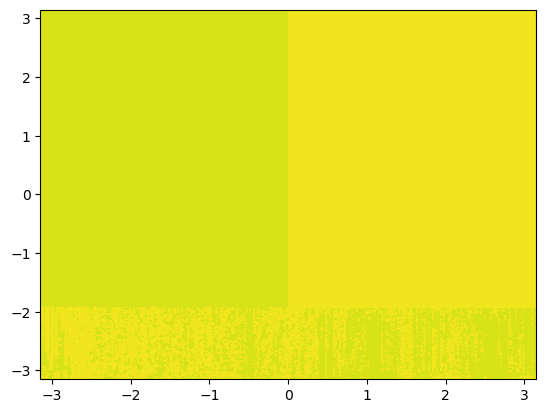

[-3.38101659e+13-3.32252608e+13j -2.88994163e+13-3.35239712e+13j
 -2.86768579e+12-2.40549857e+11j ...  2.01603966e+09+1.72336297e+09j
  2.05366825e+09+1.75989177e+09j  2.88457669e+09+1.40174987e+10j]
13408
-0.5233560419375207
-0.3361735164035493
0.7228406354437731
-2.343899328730464
(0.27672919507890437-0.2570322133358204j)
(-0.012847114081857704+0.5223406189467977j)
(-0.5048026694496077-0.5173710942498698j)
(-0.5048026694496077-0.5173710942498699j)
fx (0.759079411547439-0.2520626886388926j)
dxf (-0.048146681144788595+0.5322796683406534j)
fx/dxf (-0.5976584132863864-1.3720308813712796j)
div (-0.5976584132863862-1.3720308813712794j)
0.5344527558485352
0.5344527558485352
Time taken: 13.604246854782104


C:\Users\joejo\Miniconda3\lib\site-packages\numpy\ma\core.py:2826: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


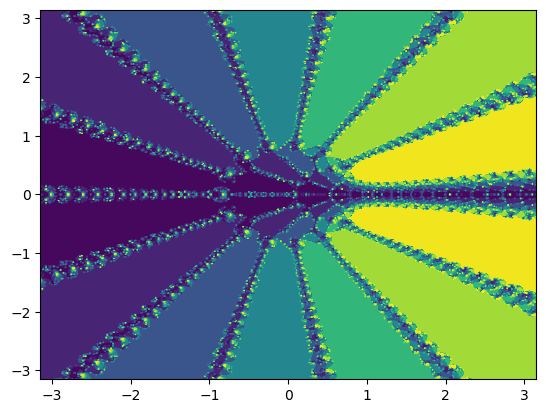

[-1. -0.2j -1. +0.2j -0.8-0.6j -0.8+0.6j -0.5-0.9j -0.5+0.9j -0.1-1.j
 -0.1+1.j   0.3-1.j   0.3+1.j   0.7-0.7j  0.7+0.7j  0.9-0.4j  0.9+0.4j]
14
1100 1510
1100 1715
1203 1305
1203 1920
1356 1152
1356 2073
1561 1100
1561 2124
1766 1100
1766 2124
1971 1254
1971 1971
2073 1408
2073 1817


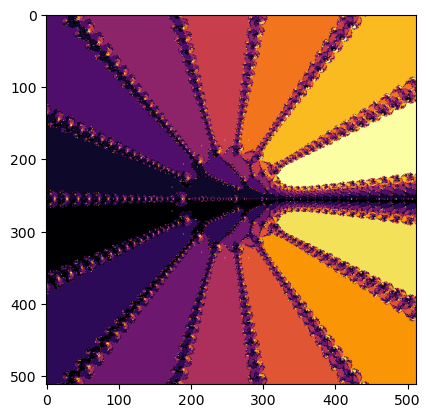

In [20]:
N=512
lim=3.15
limj=3.15j

x=np.linspace(-lim,lim,N,dtype=complex)
xj=np.linspace(-limj,limj,N,dtype=complex)
xx,yy=np.meshgrid(x,xj)
X=xx+yy
# Z=f(X)
# plt.contourf(X.real,X.imag,Z,levels=30)
# plt.show()
# plt.close()


Z=np.copy(X)
Z_out=np.copy(X)

threadsperblock = (16, 16)
blockspergrid_x = math.ceil(Z.shape[0] / threadsperblock[0])
blockspergrid_y = math.ceil(Z.shape[1] / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)

start = time.time()
get_grid_cuda[blockspergrid, threadsperblock](Z)
print("Time taken:",time.time() - start)

plt.contourf(X.real,X.imag,Z,levels=30)
plt.show()
plt.close()

roundOff=1
minima=np.unique(Z.round(roundOff))
print(minima)
print(len(minima))

print(Z[0,0].real)
print(Z[0,0].imag)

i=1
j=1
r=(Z[i,j].real**2+Z[i,j].imag**2)**0.5
exp=math.atan2(Z[i,j].imag,Z[i,j].real)
Z3=r**3*math.cos(3*exp)+r**3*math.sin(3*exp)*1j
Z2=r**2*math.cos(2*exp)+r**2*math.sin(2*exp)*1j
Z1=r**1*math.cos(1*exp)+r**1*math.sin(1*exp)*1j

fx=Z3+Z2+Z[i,j]+1
dfx=3*Z2+2*Z[i,j]+1
print(r)
print(exp)
print(Z3)
print(Z2)
print(Z1)
print(Z[i,j])
print("fx",fx)
print("dxf",dfx)

print("fx/dxf",fx/dfx)
div=((fx.real*dfx.real+fx.imag*dfx.imag)+1j*(fx.imag*dfx.real-fx.real*dfx.imag))/(dfx.real**2+dfx.imag**2)
print("div",div)
print(abs(dfx))
print((dfx.real**2+dfx.imag**2)**0.5)
  
# sys.exit()

Z=np.copy(X)

start = time.time()
Z=get_grid(Z)
print("Time taken:",time.time() - start)

plt.contourf(X.real,X.imag,Z,levels=30)
plt.show()
plt.close()


roundOff=1
minima=np.unique(Z.round(roundOff))
print(minima)
print(len(minima))

Img=np.zeros((Z.shape[0],Z.shape[1],3)).astype(np.uint8)
# cmap = matplotlib.cm.get_cmap('viridis')
cmap = matplotlib.cm.get_cmap('inferno')

for i in  range(len(minima)):
    # indx=np.argwhere(Val.round(3)==minima[i])
    indx=np.argwhere(np.flip(Z,0).round(roundOff)==minima[i])
    rgba = cmap(i/(len(minima)-1))
    Img[indx[:,0],indx[:,1],:]=np.array(rgba[:-1])*255
    # print(minima[i].real,minima[i].imag)

for i in  range(len(minima)):   
    print(int((minima[i].real+lim)*N),int((minima[i].imag+abs(limj))*N))
    x,y=int((minima[i].real+lim)/(2*lim)*N),int((minima[i].imag+abs(limj))/(2*abs(limj))*N)    
    Img = cv2.circle(Img, (x,y), radius=0, color=(255, 255, 255), thickness=-1)

Img = cv2.circle(Img, (N//2,N//2), radius=0, color=(255, 255, 255), thickness=-1)

plt.imshow(Img)
# plt.gca().set_aspect('equal')
cv2.imwrite('Fractal.png',cv2.cvtColor(Img, cv2.COLOR_RGB2BGR))
plt.show()
# plt.close()

